In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import getpass
import requests 
import json
import contextily as ctx
from pandas import ExcelWriter
import censusdata

# user = getpass.getuser()
# sys.dont_write_bytecode = True
# sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

# from utils_io import *

### Read census api key from file

In [2]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

### Read selected ACS varibles from csv

In [3]:
acs_coc_selected_vars = pd.read_csv('Data/ACS_Table_Variables_COC_Factors.csv')

In [4]:
acs_vars_lst = acs_coc_selected_vars['ACS_Table_Variable'].tolist()

### Query ACS API
#### [Census American Community Survey 5-Year Data API Documentation](https://www.census.gov/data/developers/data-sets/acs-5year.html)

In [5]:
api_file = 'census_api_key.txt'

api_key = get_file_contents(api_file)

In [6]:
var = ','.join(acs_vars_lst)
counties = '001,013,041,055,075,081,085,095,097'
state = '06'
url = 'https://api.census.gov/data/2018/acs/acs5?get={var}&for=tract:*&in=county:{counties}&in=state:{state}&key={api_key}'.format(var=var,
                                                                                                                                 counties=counties,
                                                                                                                                 state=state,
                                                                                                                                   api_key=api_key)
rq = requests.get(url)
data = rq.json()
acs_df = pd.DataFrame(data[1:],columns=data[0])

In [7]:
acs_df['county'].unique()

array(['055', '085', '095', '075', '013', '081', '001', '097', '041'],
      dtype=object)

### Change data type to integer select columns

In [8]:
acs_df[acs_vars_lst] = acs_df[acs_vars_lst].apply(pd.to_numeric)

In [9]:
acs_df['geoid'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

### Rename columns for consistancy with prior CoCs

In [10]:
cols = {'county':'county_fip',
        'B03002_001E':'tot_pop_mi',
        'B01001_001E':'tot_pop_se',
        'C17002_001E':'tot_pop_po',
       'C18108_001E':'tot_pop_ci',
       'B08201_001E':'tot_hh',
       'B11004_001E':'tot_fam',
       'B16005_001E':'tot_pop_ov',
       'B25070_010E':'pop_hus_re',
       'B08201_002E':'pop_zvhhs'}
acs_df.rename(columns=cols, inplace=True)

### Calculate CoC and populations

In [11]:
acs_df['pop_minori'] = (acs_df['tot_pop_mi'] - 
                          acs_df['B03002_003E'])
acs_df['pop_over75'] = (acs_df['B01001_023E'] + 
                        acs_df['B01001_024E'] + 
                        acs_df['B01001_025E'] + 
                        acs_df['B01001_047E'] + 
                        acs_df['B01001_048E'] + 
                        acs_df['B01001_049E'])
acs_df['pop_spfam'] = (acs_df['B11004_010E'] + 
                       acs_df['B11004_016E'])
acs_df['pop_lep'] = (acs_df['B16005_007E'] + 
                     acs_df['B16005_008E'] + 
                     acs_df['B16005_012E'] + 
                     acs_df['B16005_013E'] + 
                     acs_df['B16005_017E'] + 
                     acs_df['B16005_018E'] + 
                     acs_df['B16005_022E'] + 
                     acs_df['B16005_023E'] + 
                     acs_df['B16005_029E'] + 
                     acs_df['B16005_030E'] + 
                     acs_df['B16005_034E'] + 
                     acs_df['B16005_035E'] + 
                     acs_df['B16005_039E'] + 
                     acs_df['B16005_040E'] + 
                     acs_df['B16005_044E'] + 
                     acs_df['B16005_045E'])
acs_df['pop_below2'] = (acs_df['tot_pop_po'] - 
                          acs_df['C17002_008E'])
acs_df['pop_disabi'] = (acs_df['tot_pop_ci'] - 
                            (acs_df['C18108_005E'] + 
                             acs_df['C18108_009E'] + 
                             acs_df['C18108_013E']))

### Calculate CoC shares

In [12]:
acs_df['pct_minori'] = (np.where(acs_df['tot_pop_mi'] == 0,0,
                                   (acs_df['pop_minori']/
                                    acs_df['tot_pop_mi'])))
acs_df['pct_over75'] = (np.where(acs_df['tot_pop_se'] == 0,0,
                                 (acs_df['pop_over75']/
                                  acs_df['tot_pop_se'])))
acs_df['pct_spfam'] = (np.where(acs_df['tot_fam'] == 0,0,
                                (acs_df['pop_spfam']/
                                 acs_df['tot_fam'])))
acs_df['pct_lep'] = (np.where(acs_df['tot_pop_ov'] == 0,0,
                              (acs_df['pop_lep']/
                               acs_df['tot_pop_ov'])))
acs_df['pct_below2'] = np.where(acs_df['tot_pop_po'] == 0,0,
                                  (acs_df['pop_below2']/
                                   acs_df['tot_pop_po']))
acs_df['pct_disab'] = np.where(acs_df['tot_pop_ci'] == 0,0,
                               (acs_df['pop_disabi']/
                                acs_df['tot_pop_ci']))
acs_df['pct_zvhhs'] = np.where(acs_df['tot_hh'] == 0,0,
                               (acs_df['pop_zvhhs']/
                                acs_df['tot_hh']))
acs_df['pct_hus_re'] = np.where(acs_df['tot_hh'] == 0,0,
                                    (acs_df['pop_hus_re']/
                                     acs_df['tot_hh']))

In [13]:
acs_df.head(5)

,tot_pop_mi,B03002_003E,tot_pop_se,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_po,...,pop_below2,pop_disabi,pct_minori,pct_over75,pct_spfam,pct_lep,pct_below2,pct_disab,pct_zvhhs,pct_hus_re
0,2772,1388,2772,23,9,10,77,8,8,2580,...,873,392,0.499278,0.048701,0.297345,0.130384,0.338372,0.149675,0.135379,0.160650
1,4127,2874,4127,34,19,14,30,54,46,4125,...,591,382,0.303610,0.047734,0.054027,0.087235,0.143273,0.092561,0.005806,0.020645
2,722,396,722,23,0,0,0,0,0,119,...,103,80,0.451524,0.031856,0.363636,0.008310,0.865546,0.672269,0.891892,0.594595
3,6918,1563,6918,35,17,19,126,26,71,6845,...,460,263,0.774068,0.042498,0.033134,0.043160,0.067202,0.038155,0.021295,0.045198
4,4863,1951,4863,83,27,20,89,67,69,4863,...,776,515,0.598807,0.073000,0.084932,0.087213,0.159572,0.105902,0.099839,0.067096


### Flag cocs and coc levels (high, higher, highest) 

In [14]:
def flag_condition_calc(row, df_share_column, standard_deviation):
    cond = (df_share_column.mean().round(decimals=2) + 
            (standard_deviation * 
             df_share_column.std().round(decimals=2))).round(decimals=2)
    if row > cond:
        return 1
    else:
        return 0

In [15]:
def flag_mult_columns(dataframe, dictionary, standard_deviation):
    for key, value in dictionary.items():
        dataframe[value] = (dataframe[key]
                            .apply(
                                lambda row : flag_condition_calc(row,acs_df[key],
                                                                 standard_deviation)))

### Flag halfsd columns and count factors

In [16]:
cols_dict_halfsd = {'pct_over75':'over75_1_2',
                    'pct_minori':'minori_1_2',
                   'pct_spfam':'spfam_1_2',
                   'pct_disab':'disab_1_2',
                   'pct_lep':'lep_1_2',
                   'pct_below2':'below2_1_2',
                   'pct_zvhhs':'zvhh_1_2',
                   'pct_hus_re':'hus_re_1_2'}


In [17]:
flag_mult_columns(acs_df,cols_dict_halfsd,.5)

In [18]:
halfsd_cols_list = ['below2_1_2',
             'minori_1_2',
             'spfam_1_2',
             'disab_1_2',
             'lep_1_2',
             'over75_1_2',
             'zvhh_1_2',
             'hus_re_1_2']
acs_df['count_1_2'] = acs_df[halfsd_cols_list].sum(axis=1)

In [19]:
acs_df[halfsd_cols_list][acs_df['count_1_2'] >= 1]

,below2_1_2,minori_1_2,spfam_1_2,disab_1_2,lep_1_2,over75_1_2,zvhh_1_2,hus_re_1_2
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
3,0,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0
9,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1583,0,0,0,0,0,1,0,0
1584,0,0,0,0,0,1,0,0
1585,0,0,0,0,0,1,0,0
1586,0,0,1,1,1,1,0,0


### Flag halfsd coc

In [27]:
halfsd_remain = ['spfam_1_2',
                 'disab_1_2',
                 'lep_1_2',
                 'over75_1_2',
                 'zvhh_1_2',
                 'hus_re_1_2']
halfsd_cond = (((acs_df['minori_1_2'] == 1) & 
                (acs_df['below2_1_2'] == 1)) | 
               ((acs_df['below2_1_2'] == 1) & 
                (acs_df[halfsd_remain].sum(axis=1) >= 3))
              )
acs_df['coc50_1_2'] = np.where(halfsd_cond,1,0)

In [28]:
acs_df[halfsd_cols_list][acs_df['coc50_1_2'] == 1]

,below2_1_2,minori_1_2,spfam_1_2,disab_1_2,lep_1_2,over75_1_2,zvhh_1_2,hus_re_1_2
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
9,1,1,1,0,1,0,0,0
11,1,1,1,0,1,0,0,0
18,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1543,1,1,1,0,0,0,0,1
1544,1,1,1,0,1,0,0,1
1549,1,1,1,1,1,0,0,1
1564,1,0,1,1,1,0,0,0


### Flag onesd columns

In [29]:
cols_dict_onesd = {'pct_over75':'over75_1',
                    'pct_minori':'minori_1',
                   'pct_spfam':'spfam_1',
                   'pct_disab':'disab_1',
                   'pct_lep':'lep_1',
                   'pct_below2':'below2_1',
                   'pct_zvhhs':'zvhh_1',
                   'pct_hus_re':'hus_re_1'}

In [30]:
flag_mult_columns(acs_df,cols_dict_onesd,1)

In [31]:
onesd_cols_list = ['below2_1',
             'minori_1',
             'spfam_1',
             'disab_1',
             'lep_1',
             'over75_1',
             'zvhh_1',
             'hus_re_1']
acs_df['count_1'] = acs_df[onesd_cols_list].sum(axis=1)

### Flag onesd coc

In [33]:
onesd_remain = ['spfam_1',
                 'disab_1',
                 'lep_1',
                 'over75_1',
                 'zvhh_1',
                 'hus_re_1']
onesd_cond = (((acs_df['minori_1'] == 1) & 
                (acs_df['below2_1'] == 1)) | 
               ((acs_df['below2_1'] == 1) & 
                (acs_df[onesd_remain].sum(axis=1) >= 3))
              )
acs_df['coc50_1'] = np.where(onesd_cond,1,0)

In [34]:
acs_df[onesd_cols_list][(acs_df['coc50_1'] == 1)]

,below2_1,minori_1,spfam_1,disab_1,lep_1,over75_1,zvhh_1,hus_re_1
2,1,0,1,1,0,0,1,1
19,1,1,1,1,0,0,1,1
34,1,1,1,0,1,0,0,0
35,1,1,1,0,1,0,0,1
38,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1481,1,1,1,0,1,0,0,1
1506,1,1,1,0,1,0,0,1
1507,1,0,1,0,1,0,0,1
1527,1,0,1,0,1,0,0,1


### Flag onehalfsd columns

In [35]:
cols_dict_onehalfsd = {'pct_over75':'over75_1ha',
                    'pct_minori':'minori_1ha',
                   'pct_spfam':'spfam_1ha',
                   'pct_disab':'disab_1ha',
                   'pct_lep':'lep_1ha',
                   'pct_below2':'below2_1ha',
                   'pct_zvhhs':'zvhh_1ha',
                   'pct_hus_re':'hus_re_1ha'}

In [36]:
flag_mult_columns(acs_df,cols_dict_onehalfsd,1.5)

In [38]:
onehalfsd_cols_list = ['below2_1ha',
             'minori_1ha',
             'spfam_1ha',
             'disab_1ha',
             'lep_1ha',
             'over75_1ha',
             'zvhh_1ha',
             'hus_re_1ha']
acs_df['count_1ha'] = acs_df[onehalfsd_cols_list].sum(axis=1)

In [39]:
acs_df[onehalfsd_cols_list][acs_df['count_1ha'] >= 1]

,below2_1ha,minori_1ha,spfam_1ha,disab_1ha,lep_1ha,over75_1ha,zvhh_1ha,hus_re_1ha
0,0,0,1,0,0,0,0,0
2,1,0,1,1,0,0,1,1
9,0,0,0,0,1,0,0,0
10,0,0,0,0,1,0,0,0
11,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1549,0,1,0,0,1,0,0,0
1550,0,1,1,0,0,0,0,0
1564,0,0,0,0,1,0,0,0
1575,0,0,0,0,1,0,0,0


### Flag onehalfsd coc

In [40]:
onehalfsd_remain = ['spfam_1ha',
                 'disab_1ha',
                 'lep_1ha',
                 'over75_1ha',
                 'zvhh_1ha',
                 'hus_re_1ha']
onehalfsd_cond = (((acs_df['minori_1ha'] == 1) & 
                (acs_df['below2_1ha'] == 1)) | 
               ((acs_df['below2_1ha'] == 1) & 
                (acs_df[onehalfsd_remain].sum(axis=1) >= 3))
              )
acs_df['coc50_1ha'] = np.where(onehalfsd_cond,1,0)

In [41]:
acs_df[onehalfsd_cols_list][(acs_df['coc50_1ha'] == 1)]

,below2_1ha,minori_1ha,spfam_1ha,disab_1ha,lep_1ha,over75_1ha,zvhh_1ha,hus_re_1ha
2,1,0,1,1,0,0,1,1
19,1,0,1,1,0,0,1,1
35,1,0,1,0,1,0,0,1
51,1,0,1,1,0,0,0,1
101,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1401,1,0,0,1,1,1,1,0
1460,1,1,0,0,1,1,1,1
1466,1,1,1,1,1,1,1,0
1506,1,1,1,0,1,0,0,1


### Flag 2050 cocs

In [55]:
acs_df['coc_2050'] = np.where((acs_df['coc50_1ha'] == 1) | 
                                      (acs_df['coc50_1'] == 1) | 
                                      (acs_df['coc50_1_2']),1,0)

In [56]:
acs_df[['coc_2050',
        'coc50_1_2',
        'coc50_1',
        'coc50_1ha']][acs_df['coc_2050'] == 1]

,coc_2050,coc50_1_2,coc50_1,coc50_1ha
0,1,1,0,0
2,1,1,1,1
9,1,1,0,0
11,1,1,0,0
18,1,1,0,0
...,...,...,...,...
1543,1,1,0,0
1544,1,1,0,0
1549,1,1,1,0
1564,1,1,0,0


### Create coc classes

In [57]:
def set_coc_class(df):
    if df['coc50_1_2'] == 1:
        return 'Highest'
    elif df['coc50_1'] == 1:
        return 'Higher'
    elif df['coc50_1ha'] == 1:
        return 'High'
    else: 
        return 'NA'

In [58]:
acs_df['coc_class'] = acs_df.apply(set_coc_class,axis=1)

In [59]:
acs_df[acs_df['coc_class'] != 'NA']

,tot_pop_mi,B03002_003E,tot_pop_se,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_po,...,disab_1ha,lep_1ha,below2_1ha,zvhh_1ha,hus_re_1ha,count_1ha,coc50_1ha,coc2050,coc_class,coc_2050
0,2772,1388,2772,23,9,10,77,8,8,2580,...,0,0,0,0,0,1,0,1,Highest,1
2,722,396,722,23,0,0,0,0,0,119,...,1,0,1,1,1,5,1,1,Highest,1
9,8414,524,8414,77,0,72,158,17,17,8368,...,0,1,0,0,0,1,0,1,Highest,1
11,4855,68,4855,27,19,40,41,23,21,4790,...,0,1,0,0,0,2,0,1,Highest,1
18,5571,1096,5571,29,30,9,75,0,22,5501,...,0,0,0,0,0,0,0,1,Highest,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5565,1643,5565,23,19,46,87,12,48,5553,...,0,0,0,0,0,0,0,1,Highest,1
1544,7820,2155,7820,62,51,24,42,89,105,7674,...,0,0,0,0,0,0,0,1,Highest,1
1549,4278,157,4278,64,29,25,79,40,63,4258,...,0,1,0,0,0,2,0,1,Highest,1
1564,5481,2238,5481,98,22,19,5,62,93,5436,...,0,1,0,0,0,1,0,1,Highest,1


### Merge with PBA2040 CoC table

In [60]:
coc_pba2040 = pd.read_csv('Data/COCs_ACS2014_tbl.csv',dtype={'GEOID':str})
coc_pba2040.head(10)

,OID,GEOID,TOT_POP,POP_MINORITY,POP_OVER75,POP_SPFAM,POP_LEP,POP_BELOW200,POP_DISABILITY,POP_HUS_RENT50,...,DISAB_25,LEP_20,LOWINC_30,ZVHH_10,RENT50OCCHUS_15,SUM_6,COCFLAG_2017,COCFLAG_2013,TOT_FAM,COUNTY_FIP
0,-1,06001400100,3385,1287,289,19,80,173,223,62,...,0,0,0,0,0,0,0,0,818,1.0
1,-1,06001400200,1939,549,131,15,0,161,143,16,...,0,0,0,0,0,0,0,0,479,1.0
2,-1,06001400300,5428,2092,347,65,131,781,408,181,...,0,0,0,1,0,1,0,0,1130,1.0
3,-1,06001400400,4279,1722,182,143,43,672,551,126,...,0,0,0,0,0,0,0,0,884,1.0
4,-1,06001400500,3516,1674,113,45,64,924,339,207,...,0,0,0,1,0,1,0,0,519,1.0
5,-1,06001400600,1750,1123,85,84,65,590,215,111,...,0,0,1,1,1,3,1,1,382,1.0
6,-1,06001400700,4396,2894,284,228,93,2129,792,440,...,0,0,1,1,1,3,1,1,915,1.0
7,-1,06001400800,3218,2052,129,82,34,870,384,231,...,0,0,0,1,0,1,0,0,630,1.0
8,-1,06001400900,2031,1052,26,160,21,528,228,154,...,0,0,0,0,1,2,0,0,445,1.0
9,-1,06001401000,5505,3946,306,342,213,2502,839,785,...,0,0,1,1,1,3,1,1,1069,1.0


In [99]:
coc_pba2040['COCFLAG_2013'].dtype

dtype('int64')

In [100]:
coc_pba2050_pba2040_compare = pd.merge(acs_df,coc_pba2040[['GEOID','COCFLAG_2017','COCFLAG_2013']],
                                       left_on='geoid',
                                       right_on='GEOID',
                                      how='left')

In [101]:
coc_pba2050_pba2040_compare.head(5)

,tot_pop_mi,B03002_003E,tot_pop_se,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_po,...,zvhh_1ha,hus_re_1ha,count_1ha,coc50_1ha,coc2050,coc_class,coc_2050,GEOID,COCFLAG_2017,COCFLAG_2013
0,2772,1388,2772,23,9,10,77,8,8,2580,...,0,0,1,0,1,Highest,1,06055200202,1.0,1.0
1,4127,2874,4127,34,19,14,30,54,46,4125,...,0,0,0,0,0,NA,0,06055200400,0.0,0.0
2,722,396,722,23,0,0,0,0,0,119,...,1,1,5,1,1,Highest,1,06055200900,1.0,1.0
3,6918,1563,6918,35,17,19,126,26,71,6845,...,0,0,0,0,0,NA,0,06085508101,0.0,0.0
4,4863,1951,4863,83,27,20,89,67,69,4863,...,0,0,0,0,0,NA,0,06085509202,0.0,0.0


In [102]:
coc_pba2050_pba2040_compare.rename(columns={'COCFLAG_2017':'coc_2040','COCFLAG_2013':'coc_2035'},inplace=True)

In [105]:
coc_pba2050_pba2040_compare['coc_2035'].dtype

dtype('float64')

In [107]:
coc_pba2050_pba2040_compare['coc_2035'] = coc_pba2050_pba2040_compare['coc_2035'].fillna(0.0).astype(int)

### Sum pba2050 and pba2040 cocs for comparison

In [108]:
coc_pba2050_pba2040_compare[['coc_2040','coc_2050']].sum()

coc_2040    365.0
coc_2050    339.0
dtype: float64

### Sum pba2040 cocs and ACS2016 cocs for a sanity check
#### - Appears that CoCs are decreasing in the region from the ACS2014 figures to the ACS2018 figures

In [109]:
coc_dif_acs2014_acs2016 = pd.read_csv('Data/COC_Diff_ACS2014_ACS2016.csv')
coc_dif_acs2014_acs2016.head(5)

,Unnamed: 0,GEOID,COCFLAG_2017,COC_FLAG_2018,Gain_Loss_2014_2016
0,1,6001400100,0,0.0,0.0
1,2,6001400200,0,0.0,0.0
2,3,6001400300,0,0.0,0.0
3,4,6001400400,0,0.0,0.0
4,5,6001400500,0,0.0,0.0


In [110]:
coc_dif_acs2014_acs2016[['COCFLAG_2017','COC_FLAG_2018']].sum()

COCFLAG_2017     365.0
COC_FLAG_2018    336.0
dtype: float64

### Calculate coc gains and losses by tract for pba2040 and pba2050

In [111]:
coc_pba2050_pba2040_compare['coc_2040'].fillna(0,inplace=True)
coc_pba2050_pba2040_compare['coc_2040'] = coc_pba2050_pba2040_compare['coc_2040'].astype(int)

In [112]:
coc_pba2050_pba2040_compare['c2040_2050'] = (coc_pba2050_pba2040_compare['coc_2050'] - 
                                                        coc_pba2050_pba2040_compare['coc_2040'])

In [113]:
print('Between ACS2014 and ACS2018, COC tracts decreased by: ' 
      + coc_pba2050_pba2040_compare['c2040_2050'].sum().astype(str))

Between ACS2014 and ACS2018, COC tracts decreased by: -26


### Select subset of columns to export to csv

In [114]:
coc_select_cols = ['geoid',
                   'state',
                   'county_fip',
                   'tract',
                   'tot_pop_mi',
                   'tot_pop_po',
                   'tot_pop_ci',
                   'tot_hh',
                   'pop_zvhhs',
                   'tot_fam',
                   'tot_pop_ov',
                   'pop_hus_re',
                   'pop_minori',
                   'pop_over75',
                   'pop_spfam',
                   'pop_lep',
                   'pop_below2',
                   'pop_disabi',
                   'pct_minori',
                   'pct_over75',
                   'pct_spfam',
                   'pct_lep',
                   'pct_below2',
                   'pct_disab',
                   'pct_zvhhs',
                   'pct_hus_re',
                   'over75_1_2',
                   'minori_1_2',
                   'spfam_1_2',
                   'disab_1_2',
                   'lep_1_2',
                   'below2_1_2',
                   'zvhh_1_2',
                   'hus_re_1_2',
                   'coc_2035',
                   'coc_2040',
                   'coc_2050',
                   'c2040_2050', 
                   'coc_class']

In [115]:
cocs_pba2050 = coc_pba2050_pba2040_compare[coc_select_cols].copy()

In [116]:
cocs_pba2050.rename(columns={'tot_pop_mi':'tot_pop'},inplace=True)

In [117]:
cocs_pba2050

,geoid,state,county_fip,tract,tot_pop,tot_pop_po,tot_pop_ci,tot_hh,pop_zvhhs,tot_fam,...,disab_1_2,lep_1_2,below2_1_2,zvhh_1_2,hus_re_1_2,coc_2035,coc_2040,coc_2050,c2040_2050,coc_class
0,06055200202,06,055,200202,2772,2580,2619,1108,150,565,...,1,1,1,0,1,1,1,1,0,Highest
1,06055200400,06,055,200400,4127,4125,4127,1550,9,981,...,0,0,0,0,0,0,0,0,0,NA
2,06055200900,06,055,200900,722,119,119,37,33,11,...,1,0,1,1,1,1,1,1,0,Highest
3,06085508101,06,085,508101,6918,6845,6893,2301,49,1841,...,0,0,0,0,0,0,0,0,0,NA
4,06085509202,06,085,509202,4863,4863,4863,1863,186,1095,...,0,0,0,0,0,0,0,0,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,06055201401,06,055,201401,3203,3192,3203,1193,55,960,...,0,0,0,0,0,0,0,0,0,NA
1584,06055201402,06,055,201402,3055,3032,3050,1206,9,975,...,0,0,0,0,0,0,0,0,0,NA
1585,06055201403,06,055,201403,682,656,682,279,15,204,...,0,0,0,0,0,0,0,0,0,NA
1586,06055201601,06,055,201601,2684,2684,2684,1065,42,665,...,1,1,0,0,0,1,1,0,-1,NA


In [118]:
cocs_pba2050.to_csv('Data/COCs_ACS2018_tbl.csv',index=False)

### Calculate regional statistics 

In [119]:
coc_region_stats = acs_df.agg({'pct_over75': ['mean','std'],
           'pct_minori': ['mean','std'],
           'pct_lep': ['mean','std'],
           'pct_spfam': ['mean','std'],
           'pct_below2': ['mean','std'],
           'pct_disab': ['mean','std'],
           'pct_zvhhs': ['mean','std'],
           'pct_hus_re': ['mean','std']}).transpose().reset_index()

In [120]:
coc_region_stats.rename(columns={'index':'factors'},inplace=True)

In [121]:
coc_region_stats

,factors,mean,std
0,pct_over75,0.064338,0.045397
1,pct_minori,0.583119,0.237270
2,pct_lep,0.078371,0.075754
3,pct_spfam,0.126049,0.091361
4,pct_below2,0.214262,0.142700
5,pct_disab,0.099265,0.045019
6,pct_zvhhs,0.090633,0.124128
7,pct_hus_re,0.099591,0.078651


In [122]:
coc_factors = {'pct_over75': 'Seniors 75 Years and Over',
           'pct_minori': 'Minorities',
           'pct_lep': 'Limited English Proficiency',
           'pct_spfam': 'Single Parent Families',
           'pct_below2': 'Low-Income (<200% Federal Poverty Level-FPL)',
           'pct_disab': 'People with Disability',
           'pct_zvhhs': 'Zero-Vehicle Household',
           'pct_hus_re': 'Rent-Burdened'}
coc_region_stats['factors'].replace(coc_factors,inplace=True)

In [123]:
coc_region_stats['mean'] = coc_region_stats['mean'].round(decimals=2)
coc_region_stats['std'] = coc_region_stats['std'].round(decimals=2)

### Create fields for .5, 1, and 1.5 sd from mean

In [124]:
coc_region_stats['plus_half_sd'] = (coc_region_stats['mean'] + 
                                    (.5 * coc_region_stats['std'])).round(decimals=2)
coc_region_stats['plus_one_sd'] = (coc_region_stats['mean'] + 
                                   coc_region_stats['std']).round(decimals=2)
coc_region_stats['plus_one_half_sd'] = (coc_region_stats['mean'] + 
                                       (1.5 * coc_region_stats['std'])).round(decimals=2)

In [125]:
coc_region_stats

,factors,mean,std,plus_half_sd,plus_one_sd,plus_one_half_sd
0,Seniors 75 Years and Over,0.06,0.05,0.08,0.11,0.14
1,Minorities,0.58,0.24,0.70,0.82,0.94
2,Limited English Proficiency,0.08,0.08,0.12,0.16,0.20
3,Single Parent Families,0.13,0.09,0.18,0.22,0.26
4,Low-Income (<200% Federal Poverty Level-FPL),0.21,0.14,0.28,0.35,0.42
5,People with Disability,0.10,0.05,0.12,0.15,0.18
6,Zero-Vehicle Household,0.09,0.12,0.15,0.21,0.27
7,Rent-Burdened,0.10,0.08,0.14,0.18,0.22


In [126]:
coc_region_stats.to_csv('Data/COC_Regional_Stats_ACS2018.csv',index=False)

### Query Census TIGER Tracts to get Bay Area Census Tract geography

#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [127]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID&f=geojson'.format(state=state,counties=counties)

In [128]:
print(url)

https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE='06'+AND+COUNTY+IN('001','013','041','055','075','081','085','095','097')&outFields=GEOID&f=geojson


In [129]:
geo_rq = requests.get(url)
tracts_json = geo_rq.json()

In [130]:
tracts_2018_gdf = gp.GeoDataFrame.from_features(tracts_json['features'],crs=tracts_json['crs']['properties']['name'])

In [131]:
print(tracts_2018_gdf.crs)

EPSG:4326


In [132]:
tracts_2018_gdf.head(5)

,geometry,GEOID
0,"POLYGON ((-122.24692 37.88544, -122.24683 37.8...",06001400100
1,"POLYGON ((-122.25742 37.84310, -122.25792 37.8...",06001400200
2,"POLYGON ((-122.26416 37.84000, -122.26563 37.8...",06001400300
3,"POLYGON ((-122.27789 37.84751, -122.27798 37.8...",06001400700
4,"POLYGON ((-122.28873 37.84996, -122.28787 37.8...",06001400800


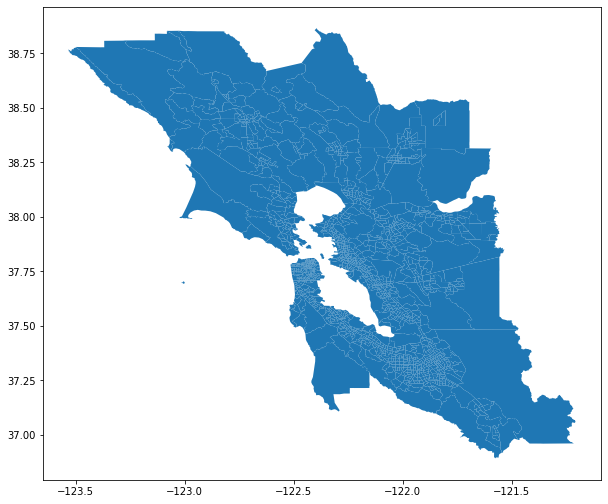

In [133]:
tracts_2018_gdf.plot(figsize=(10,10))

### Join census tracts to coc df

In [134]:
coc_tracts_pba2050 = pd.merge(tracts_2018_gdf,cocs_pba2050, left_on='GEOID',right_on='geoid',how='inner')

In [135]:
coc_tracts_pba2050.head(5)

,geometry,GEOID,geoid,state,county_fip,tract,tot_pop,tot_pop_po,tot_pop_ci,tot_hh,...,disab_1_2,lep_1_2,below2_1_2,zvhh_1_2,hus_re_1_2,coc_2035,coc_2040,coc_2050,c2040_2050,coc_class
0,"POLYGON ((-122.24692 37.88544, -122.24683 37.8...",06001400100,06001400100,06,001,400100,3115,3105,3115,1297,...,0,0,0,0,0,0,0,0,0,NA
1,"POLYGON ((-122.25742 37.84310, -122.25792 37.8...",06001400200,06001400200,06,001,400200,2025,2018,2025,855,...,0,0,0,0,0,0,0,0,0,NA
2,"POLYGON ((-122.26416 37.84000, -122.26563 37.8...",06001400300,06001400300,06,001,400300,5000,4962,5000,2441,...,0,0,0,1,0,0,0,0,0,NA
3,"POLYGON ((-122.27789 37.84751, -122.27798 37.8...",06001400700,06001400700,06,001,400700,5116,5106,5116,1947,...,1,0,1,0,0,1,1,0,-1,NA
4,"POLYGON ((-122.28873 37.84996, -122.28787 37.8...",06001400800,06001400800,06,001,400800,3792,3792,3792,1626,...,0,0,1,0,1,0,0,0,0,NA


In [136]:
coc_tracts_pba2050['coc_2050'].sum()

339

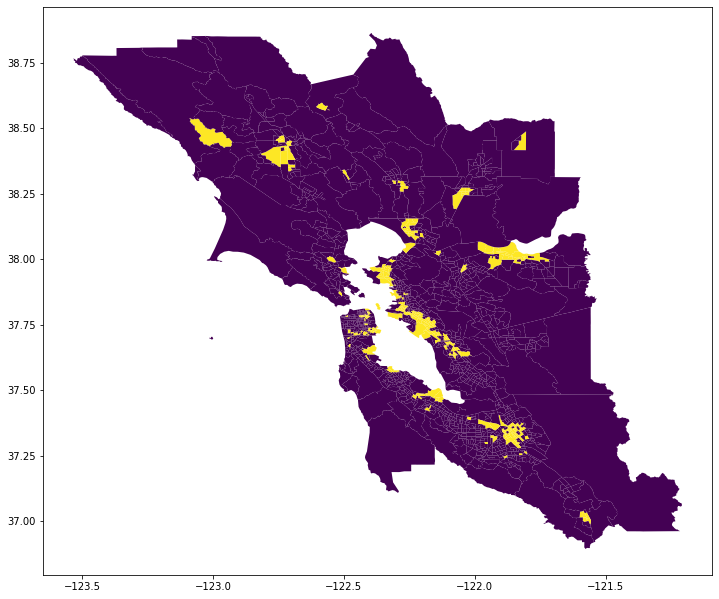

In [137]:
coc_tracts_pba2050.plot(figsize=(12,12),column='coc_2050')

In [138]:
coc_tracts_pba2050.drop('GEOID', axis=1, inplace=True)

In [140]:
coc_tracts_pba2050.to_file("Data/COCs_ACS2018_geog.geojson", driver="GeoJSON")